In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline 

In [70]:
class Linear():#(dim2*dim1)*(dim1*1)+(dim2*1)
    def __init__(self, input_dim, output_dim):
        self.shape = (input_dim,output_dim)
        self.weight = np.random.normal(loc = 0, scale = 1, size = (output_dim, input_dim))
        self.bias = np.zeros((output_dim,1))

    def forward(self, input):
        #input = input.transpose()
        #print("shape of input", np.shape(input))
        res = np.matmul(self.weight, input) 
        #print("shape of output", np.shape(res))
        res = res + self.bias
        #print("shape of output", np.shape(res))
        return res
        


In [71]:
class BP():
    def __init__(self, input_dim, output_dim, dataset, learning_rate = 0.5, layernum = 6):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dataset = dataset
        self.layernum = layernum
        self.learning_rate = learning_rate
        """self.layers[0] = Linear(input_dim, 16)
        self.layers[1] = Linear(16, 16)
        self.layers[2] = Linear(16, 8)
        self.layers[3] = Linear(8,output_dim)
        """
        #self.layers = (Linear(input_dim, 16), Linear(16, 16), Linear(16, 8), Linear(8, output_dim))
        self.layers = (Linear(input_dim, 16), Linear(16, 16), Linear(16, 32), Linear(32, 16), Linear(16, 8), Linear(8, output_dim))
        self.checkpoint = [1,2,3,4,5,6,7,8,9,10]
        if(output_dim == 2):
            np.random.shuffle(self.dataset)
        self.validationset, self.trainset = np.split(self.dataset,[int(self.dataset.shape[0]/4)],axis = 0)

        

    def sigmoid(self, input):
        return 1.0/(1+np.exp(-input))

    def softmax(self, input):
        tempexp = np.exp(input)
        return (tempexp)/(np.sum(tempexp, axis = 0))
    
    def test(self):
        """temp = np.ones((5, 1))
        print("temp is ", temp)
        print("sigmoid is ", self.sigmoid(temp))
        print("softmax is ", self.softmax(temp))
        """
        """
        print(np.shape(self.layers[1].weight))
        print(self.layers[1].weight)
        """
        
        #test forward
        testinput = np.random.rand(1,8)
        testoutput = self.forward(testinput)
    
    def forward(self, input):
        output = input.transpose()
        self.checkpoint[0] = output
        for i in range(int(self.layernum)):
            output = self.layers[i].forward(output)
            output = self.sigmoid(output)
            self.checkpoint[i+1] = output
        predict = self.softmax(output)
        return predict
    
    def crossentropyloss(self, true, predict):
        #a = np.array([0.001,0.001,0.001])
        a = np.full(self.output_dim, 0.5)
        #print(predict)
        predict = predict + a
        temp = np.log(predict)
        temp = np.multiply(temp, true)#对应元素相乘
        return np.sum(temp, axis = 0)[0]

    def total_loss(self, data):#计算某一个数据集或者某一个batach上总的损失值
        total = 0
        data_x, data_y = np.split(data,[data.shape[1]-1],axis = 1) #分割featrure and label
        #data_x = data_x / data_x.max(axis=0)
        for i in range(0, data.shape[0], 1):
            x = data_x[i]
            y = data_y[i]
            #将y的label值转换为one hot vector
            labely = np.zeros((1, self.output_dim))
            labely[0][int(y)] = 1
            total = total + self.crossentropyloss(labely, self.forward(x).transpose())
            #这里数据类型之类的东西要仔细检查一下 
        return total

    def backward(self, true, predict):#这里的缺陷在于不是batch的SGD
        previous_gradient = predict - true
        for i in range(self.layernum - 1, -1, -1):
            checkpoint = self.checkpoint[i+1]
            current_gradient = np.multiply(checkpoint, (1 - checkpoint))
            current_gradient = np.multiply(current_gradient, previous_gradient)
            gradient_w = np.matmul(current_gradient, self.checkpoint[i].transpose())
            gradient_b = current_gradient#
            previous_gradient = np.matmul(self.layers[i].weight.transpose(), current_gradient)#先把梯度传下去，然后再更新
            
            self.layers[i].weight = self.layers[i].weight - self.learning_rate * gradient_w
            self.layers[i].bias = self.layers[i].bias - self.learning_rate * gradient_b

    def train(self, batchsize, epoch):
        TrainLoss = np.zeros((epoch))
        ValidationLoss = np.zeros((epoch))
        for i in range(0, epoch, 1):
            np.random.shuffle(self.trainset)
            data_x, data_y = np.split(self.trainset,[self.trainset.shape[1]-1],axis = 1)
            #print(data_x.max(axis = 0))
            #data_x = data_x / data_x.max(axis=0)
            
            for j in range(0, batchsize, 1):
                x = data_x[j]
                y = data_y[j]
                #print(x)
                #print(y)
                x = np.expand_dims(x, axis=0)
                predict = self.forward(x)
                labely = np.zeros((1, self.output_dim))
                labely[0][int(y)] = 1
                self.backward(labely.transpose(),predict)
            #TrainLoss[i] = self.total_loss(self.trainset)
            ValidationLoss[i] = self.total_loss(self.validationset)
        self.display(TrainLoss, ValidationLoss)

    def display(self, TrainLoss, ValidationLoss):
        epoch = TrainLoss.shape[0]
        epoch = np.arange(epoch)
        plt.figure()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        #plt.plot(epoch, TrainLoss, label = "Train", color = 'r')
        plt.plot(epoch, ValidationLoss, label = "Validation")
        plt.legend()
            




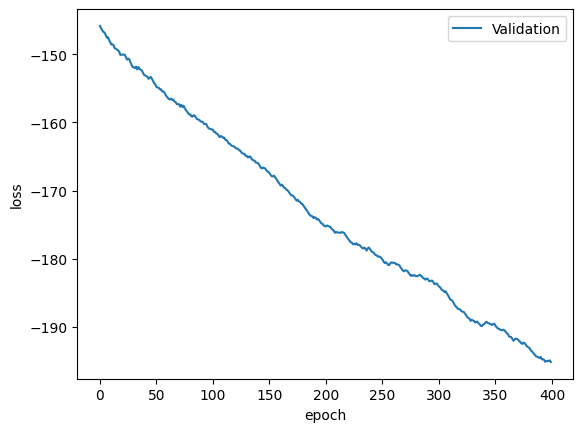

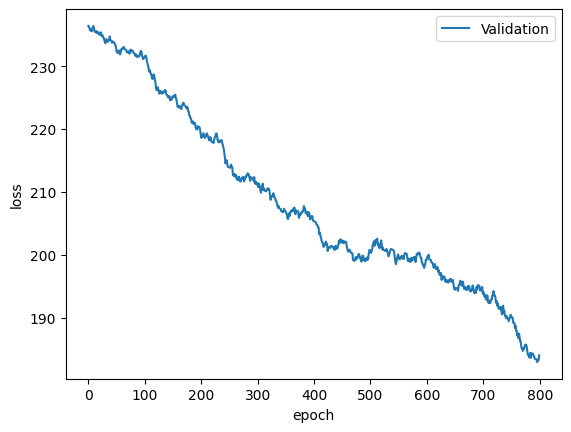

In [72]:
dataset1 = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/iris.csv')
dataset1 = np.array(dataset1.values)
dataset2 = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/titanic.csv')
dataset2 = np.array(dataset2.values)
BP1 = BP(4, 3, dataset1, 0.005)
BP1.train(5, 400)
dataset2 = dataset2 / dataset2.max(axis=0)
BP2 = BP(7, 2, dataset2, 0.003)
BP2.train(5, 800)
